In [1]:
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
from keras.utils import plot_model,multi_gpu_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import Model
from keras.models import load_model
from keras.layers import Input,GlobalAveragePooling2D,Layer,InputSpec
from keras.layers.core import Dense,Flatten,Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils
import keras.backend as K
import keras.layers as kl
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from time import time
import pickle
from AttentionModule import CrossAttention, SoftAttention, ResidualCombine2D
import os, sys, shutil
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"
import cv2
from tqdm import tqdm_notebook
# from coord import CoordinateChannel2D
from sklearn.model_selection import KFold
from scipy import misc
from itertools import combinations
pd.options.display.max_colwidth = 100
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

Using TensorFlow backend.


In [2]:
n_gpu=3
n_cpu=1
tf_config= tf.ConfigProto(device_count = {'GPU': n_gpu , 'CPU': n_cpu})
tf_config.gpu_options.allow_growth=True
s=tf.Session(config=tf_config)
K.set_session(s)

In [3]:
ds_folder = 'dataset/all'
ds = np.array(os.listdir(ds_folder))
np.random.shuffle(ds)
ds[:10]

array(['0333b_num1.png', '1066b_num1.png', '0883c_num1.png',
       '1412a_num3.png', '1257c_num2.png', '1402b_num2.png',
       '1129a_num1.png', '0640a_num2.png', '0370a_num1.png',
       '1442a_num1.png'], dtype='<U15')

In [4]:
# kf = KFold(n_splits=5, shuffle=False)
# kf.get_n_splits(ds)

In [5]:
# def generateDatasetAndSave(ids, fold_count, mode):
#     label = []
#     left_path = []
#     right_path = []
#     simCounter = 0
#     diffCounter = 0
#     x = ds[ids]
#     combs = combinations(x,2)
#     combs = list(combs)
#     np.random.shuffle(combs)
#     for l,r in tqdm_notebook(combs):
#         if(int(l[:4]) == int(r[:4])):
#             label.append(1)
#             left_path.append(l)
#             right_path.append(r)
#             simCounter+=1 
#     for l,r in tqdm_notebook(combs):
#         if(int(l[:4]) != int(r[:4])):
#             label.append(0)
#             left_path.append(l)
#             right_path.append(r)
#             diffCounter+=1
#         if(diffCounter==simCounter*10):
#             break
#     df = pd.DataFrame()
#     df['left'] = left_path
#     df['right'] = right_path
#     df['label'] = label
#     if not os.path.exists('dataset/kfold_csvs/fold_'+str(fold_count)):
#         os.mkdir('dataset/kfold_csvs/fold_'+str(fold_count))
#     df.to_csv('dataset/kfold_csvs/fold_'+str(fold_count)+'/'+mode+'.csv')

In [6]:
def blockA(x,i):  
    x_1 = kl.Conv2D(filters=32,padding='same',kernel_size=1,strides=1,name='blockA_1'+str(i),activation='relu')(x)
    x_1 = kl.BatchNormalization()(x_1)
    
    x_2 = kl.Conv2D(filters=32,padding='same',kernel_size=1,strides=1,name='blockA_2'+str(i),activation='relu')(x)
    x_2 = kl.Conv2D(filters=32,padding='same',kernel_size=3,strides=1,name='blockA_3'+str(i),activation='relu')(x_2)
    x_2 = kl.BatchNormalization()(x_2)
    
    x_3 = kl.Conv2D(filters=32,padding='same',kernel_size=1,strides=1,name='blockA_4'+str(i),activation='relu')(x)
    x_3 = kl.Conv2D(filters=48,padding='same',kernel_size=3,strides=1,name='blockA_5'+str(i),activation='relu')(x_3)
    x_3 = kl.Conv2D(filters=64,padding='same',kernel_size=3,strides=1,name='blockA_6'+str(i),activation='relu')(x_3)
    x_3 = kl.BatchNormalization()(x_3)
    
    a = kl.concatenate([x_1,x_2,x_3])
    a = kl.Conv2D(filters=int(x.shape[-1]),padding='same',kernel_size=1,strides=1,name='blockA_7'+str(i),activation='relu')(a)
    a = kl.BatchNormalization()(a)
    a = kl.Add(name='blockA_add_'+str(i))([a,x])
    a = kl.Conv2D(filters=256,padding='same',kernel_size=1,strides=1,activation='relu')(a)
    
    return a
def blockB(x,i):
    x_1 = kl.Conv2D(filters=192,padding='same',kernel_size=1,strides=1,name='blockB_1'+str(i),activation='relu')(x)
    x_1 = kl.BatchNormalization()(x_1)
    
    x_2 = kl.Conv2D(filters=128,padding='same',kernel_size=1,strides=1,name='blockB_2'+str(i),activation='relu')(x)
    x_2 = kl.Conv2D(filters=160,padding='same',kernel_size=(5,1),strides=1,name='blockB_3'+str(i),activation='relu')(x_2)
    x_2 = kl.Conv2D(filters=192,padding='same',kernel_size=(1,5),strides=1,name='blockB_4'+str(i),activation='relu')(x_2)
    x_2 = kl.BatchNormalization()(x_2)
    
    a = kl.concatenate([x_1,x_2])
    a = kl.Conv2D(filters=int(x.shape[-1]),padding='same',kernel_size=1,strides=1,name='blockB_5'+str(i),activation='relu')(a)
    a = kl.BatchNormalization()(a)
    a = kl.Add(name='blockB_add_'+str(i))([a,x])
    a = kl.Conv2D(filters=512,padding='same',kernel_size=1,strides=1,activation='relu')(a)
    return a
def blockC(x,i):
    x_1 = kl.Conv2D(filters=192,padding='same',kernel_size=1,strides=1,name='blockC_1'+str(i),activation='relu')(x)
    x_1 = kl.BatchNormalization()(x_1)
    
    x_2 = kl.Conv2D(filters=192,padding='same',kernel_size=1,strides=1,name='blockC_2'+str(i),activation='relu')(x)
    x_2 = kl.Conv2D(filters=224,padding='same',kernel_size=(3,1),strides=1,name='blockC_3'+str(i),activation='relu')(x_2)
    x_2 = kl.Conv2D(filters=256,padding='same',kernel_size=(1,3),strides=1,name='blockC_4'+str(i),activation='relu')(x_2)
    x_2 = kl.BatchNormalization()(x_2)
    
    a = kl.concatenate([x_1,x_2])
    a = kl.Conv2D(filters=int(x.shape[-1]),padding='same',kernel_size=1,strides=1,name='blockC_5'+str(i),activation='relu')(a)
    a = kl.BatchNormalization()(a)
    a = kl.Add(name='blockC_add_'+str(i))([a,x])
    a = kl.Conv2D(filters=1024,padding='same',kernel_size=1,strides=1,activation='relu')(a)
    return a
def reductionA(x,name=''):
    ml_0 = kl.MaxPool2D(strides=2,pool_size=3, padding='same')(x)
    
    ml_1 = kl.Conv2D(filters=384,padding='same',kernel_size=3,strides=2,activation='relu')(x)
    ml_1 = kl.BatchNormalization()(ml_1)
    
    ml_2 = kl.Conv2D(filters=256,padding='same',kernel_size=1,strides=1,activation='relu')(x)
    ml_2 = kl.Conv2D(filters=256,padding='same',kernel_size=3,strides=1,activation='relu')(ml_2)
    ml_2 = kl.Conv2D(filters=384,padding='same',kernel_size=3,strides=2,activation='relu')(ml_2)
    ml_2 = kl.BatchNormalization()(ml_2)
    
    xsa3,samap3 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(x.shape[-1]),name='soft_attention_3')(x)
    xsa3 = kl.MaxPooling2D(pool_size=(2,2),padding='same')(xsa3)
    
    ml = kl.concatenate([ml_0,ml_1,ml_2,xsa3])
    ml = kl.Activation('relu')(ml)
    ml = kl.Dropout(0.5)(ml)
    return ml


def reductionB(x,name=''):
    ml_0 = kl.MaxPool2D(strides=2,pool_size=3, padding='same')(x)
    
    ml_1 = kl.Conv2D(filters=256,padding='same',kernel_size=1,strides=1,activation='relu')(x)
    ml_1 = kl.Conv2D(filters=288,padding='same',kernel_size=3,strides=2,activation='relu')(ml_1)
    ml_1 = kl.BatchNormalization()(ml_1)
    
    ml_2 = kl.Conv2D(filters=256,padding='same',kernel_size=1,strides=1,activation='relu')(x)
    ml_2 = kl.Conv2D(filters=288,padding='same',kernel_size=3,strides=2,activation='relu')(ml_2)
    ml_2 = kl.BatchNormalization()(ml_2)
    
    ml_3 = kl.Conv2D(filters=256,padding='same',kernel_size=1,strides=1,activation='relu')(x)
    ml_3 = kl.Conv2D(filters=288,padding='same',kernel_size=3,strides=1,activation='relu')(ml_3)
    ml_3 = kl.Conv2D(filters=320,padding='same',kernel_size=3,strides=2,activation='relu')(ml_3)
    ml_3 = kl.BatchNormalization()(ml_3)
    
    xsa4,samap4 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(x.shape[-1]),name='soft_attention_4')(x)
    xsa4 = kl.MaxPooling2D(pool_size=(2,2),padding='same')(xsa4)
    
    ml = kl.concatenate([ml_0,ml_1,ml_2,ml_3,xsa4])
    ml = kl.Activation('relu')(ml)
    ml = kl.Dropout(0.5)(ml)
    return ml

def stem(ml):
    ml = kl.Conv2D(filters=32,padding='same',kernel_size=3,strides=1,name='stem1',activation='relu')(ml)
    ml = kl.Conv2D(filters=32,padding='same',kernel_size=3,strides=1,name='stem2',activation='relu')(ml)
    ml = kl.Conv2D(filters=64,padding='same',kernel_size=3,strides=1,name='stem3',activation='relu')(ml)
    ml = kl.BatchNormalization()(ml)
    a = kl.MaxPool2D(pool_size=3, strides=2, padding='same')(ml)
    b = kl.Conv2D(filters=96,padding='same',kernel_size=3,strides=2,activation='relu')(ml)
    xsa1,samap1 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(ml.shape[-1]),name='soft_attention_1')(ml)
    xsa1 = kl.MaxPooling2D(pool_size=(2,2),padding='same')(xsa1)
    ml = kl.concatenate([a,b,xsa1])
    ml = kl.Activation('relu')(ml)
    ml = kl.Dropout(0.5)(ml)
    
    
    
    a = kl.Conv2D(filters=64,padding='same',kernel_size=1,strides=1,name='stem4',activation='relu')(ml)
    a = kl.Conv2D(filters=96,padding='same',kernel_size=3,strides=1,name='stem5',activation='relu')(a)
    a = kl.BatchNormalization()(a)
    
    b = kl.Conv2D(filters=64,padding='same',kernel_size=1,strides=1,name='stem6',activation='relu')(ml)
    b = kl.Conv2D(filters=64,padding='same',kernel_size=(7,1),strides=1,name='stem7',activation='relu')(b)
    b = kl.Conv2D(filters=64,padding='same',kernel_size=(1,7),strides=1,name='stem8',activation='relu')(b)
    b = kl.Conv2D(filters=96,padding='same',kernel_size=3,strides=1,name='stem9',activation='relu')(b)
    b = kl.BatchNormalization()(b)
    ml = kl.concatenate([a,b],name='stem9_concat')
    ml = kl.Activation('relu')(ml)
    ml = kl.Dropout(0.5)(ml)
    
    a = kl.MaxPool2D(pool_size=3, strides=2,padding='same')(ml)
    b = kl.Conv2D(filters=192,padding='same',kernel_size=3,strides=2,activation='relu')(ml)
    xsa2,samap2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(ml.shape[-1]),name='soft_attention_2')(ml)
    xsa2 = kl.MaxPooling2D(pool_size=(2,2),padding='same')(xsa2)
    ml = kl.concatenate([a,b,xsa2])
    ml = kl.Activation('relu')(ml)
    ml = kl.Dropout(0.5)(ml)
    return ml

In [7]:
nb_blockA=1
nb_blockB=2
nb_blockC=1
inp = kl.Input(shape=(64,64,1),name='inp')
# ml,inp_a_map = SoftAttention(ch=int(inp.shape[-1]),return_x=True,m=32,aggregate=True,name='soft_attn_input')(inp)
g = stem(inp)
for i in range(nb_blockA):
    g = blockA(x=g,i=i)
    g = kl.Dropout(0.5)(g)
feat_ext_A = Model (inp,g)
feat_ext_A.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp (InputLayer)                (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
stem1 (Conv2D)                  (None, 64, 64, 32)   320         inp[0][0]                        
__________________________________________________________________________________________________
stem2 (Conv2D)                  (None, 64, 64, 32)   9248        stem1[0][0]                      
__________________________________________________________________________________________________
stem3 (Conv2D)                  (None, 64, 64, 64)   18496       stem2[0][0]                      
__________________________________________________________________________________________________
batch_norm

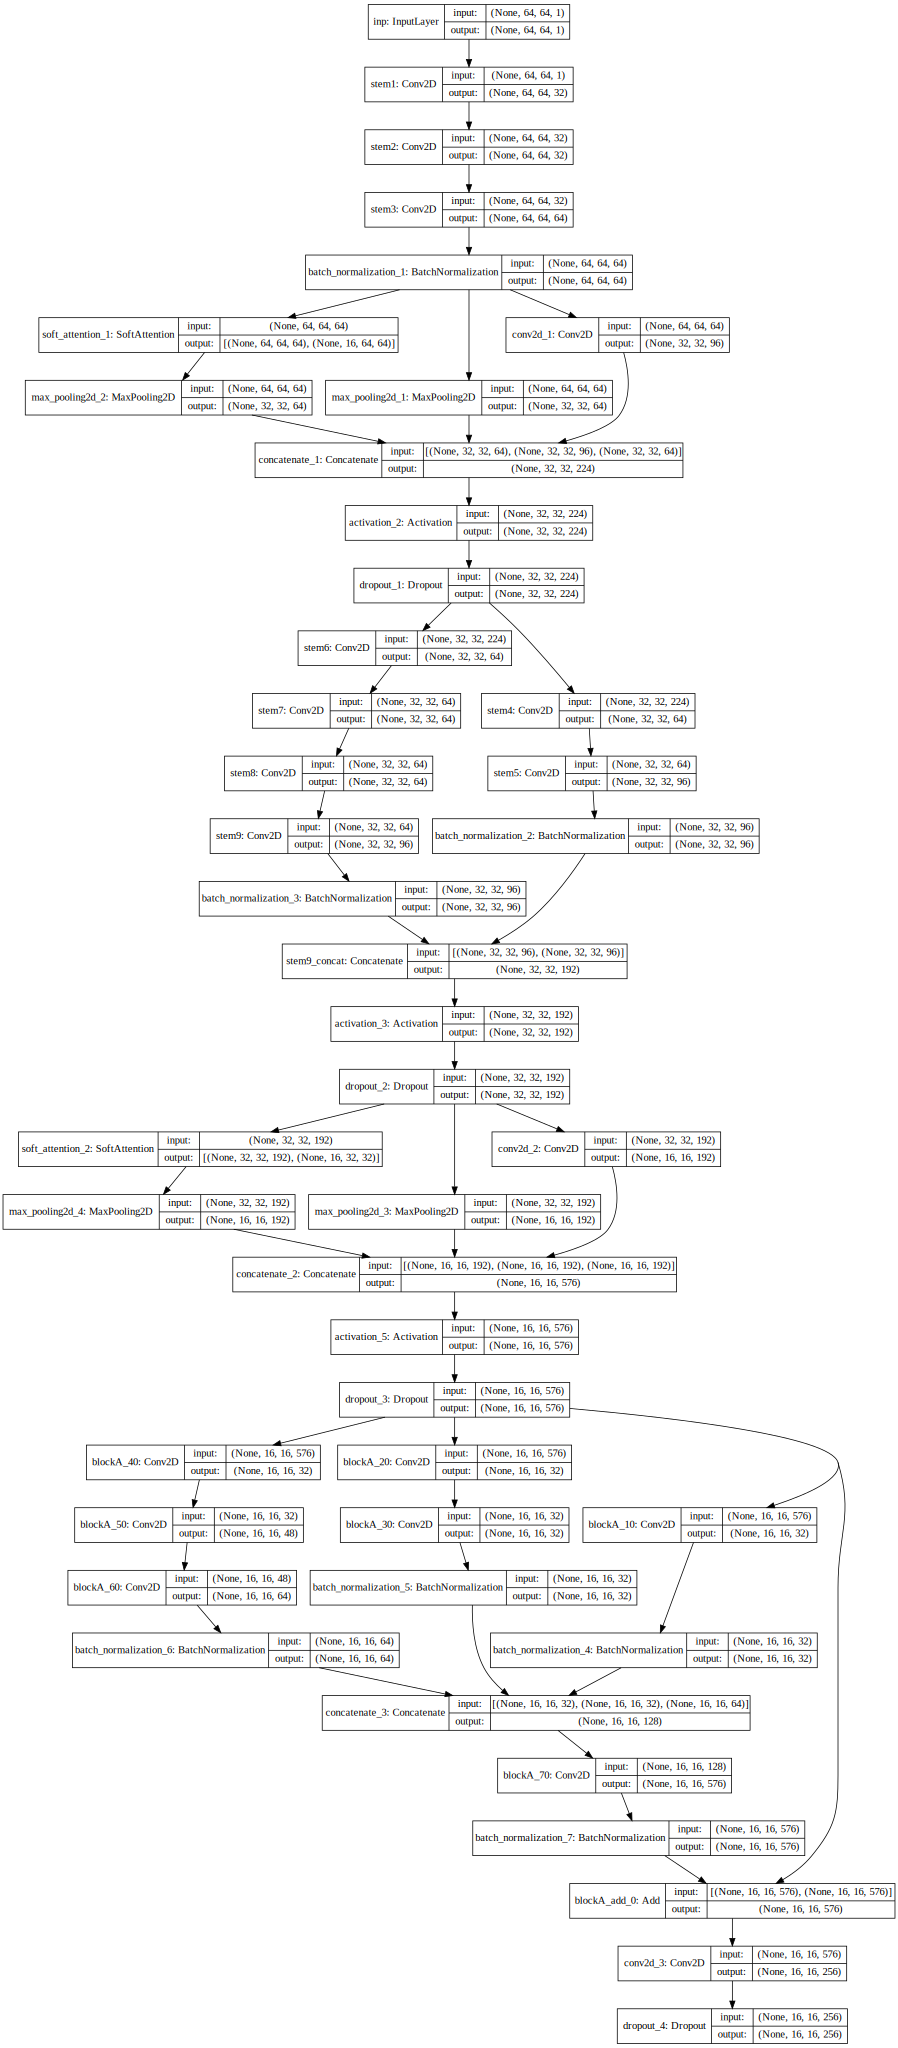

In [8]:
SVG(model_to_dot(feat_ext_A,show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [9]:
l_inp = kl.Input(shape=(64,64,1),name='l')
r_inp = kl.Input(shape=(64,64,1),name='r')
left_feats = feat_ext_A(l_inp)
right_feats = feat_ext_A(r_inp)

In [10]:
att_l_1,l_map_1 = CrossAttention(ch=int(left_feats.shape[-1]),name='ca_l2r_1')([left_feats,right_feats]) #[k,q]
att_l_1 = kl.BatchNormalization()(att_l_1)
att_l_2,l_map_2 = CrossAttention(ch=int(left_feats.shape[-1]),name='ca_l2r_2')([left_feats,right_feats]) #[k,q]
att_l_2 = kl.BatchNormalization()(att_l_2)
att_l_conc = kl.Concatenate(name='ca_l2r_concat')([att_l_1,att_l_2])
att_l_conc = kl.Activation('relu')(att_l_conc)
l2r_comb,l2r_g1,l2r_g2 = ResidualCombine2D(ch_in=int(att_l_conc.shape[-1]),ch_out=512,name='ca_l2r_comb')([left_feats,att_l_conc])
l2r_comb = kl.BatchNormalization()(l2r_comb)

att_r_1,r_map_1 = CrossAttention(ch=int(right_feats.shape[-1]),name='ca_r2l_1')([right_feats,left_feats])#[k,q]
att_r_1 = kl.BatchNormalization()(att_r_1)
att_r_2,r_map_2 = CrossAttention(ch=int(right_feats.shape[-1]),name='ca_r2l_2')([right_feats,left_feats])#[k,q]
att_r_2 = kl.BatchNormalization()(att_r_2)
att_r_conc = kl.Concatenate(name='ca_r2l_concat')([att_r_1,att_r_2])
att_r_conc = kl.Activation('relu')(att_r_conc)
r2l_comb,r2l_g1,r2l_g2 = ResidualCombine2D(ch_in=int(att_r_conc.shape[-1]),ch_out=512,name='ca_r2l_comb')([right_feats,att_r_conc])
r2l_comb = kl.BatchNormalization()(r2l_comb)

In [11]:
all_concat = kl.Concatenate()([l2r_comb,r2l_comb])
all_concat = kl.Activation('relu')(all_concat)

In [12]:

g = reductionA(x=all_concat,name='reduce_A')
for i in range(nb_blockB):
    g = blockB(x=g,i=i)
g = reductionB(x=g,name='reduce_B')
for i in range(nb_blockC):
    g = blockC(x=g,i=i)
xsa5,samap5 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(g.shape[-1]),name='soft_attention_5')(g)
g = kl.Concatenate()([g,xsa5])
g = kl.Dropout(0.5)(g)
g = kl.Flatten()(g)
g = kl.Dropout(0.5)(g)
g = kl.Dense(2,activation='softmax',name='y')(g)
model = Model(inputs = [l_inp,r_inp],outputs = g)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
l (InputLayer)                  (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
r (InputLayer)                  (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 16, 16, 256)  981456      l[0][0]                          
                                                                 r[0][0]                          
__________________________________________________________________________________________________
ca_l2r_1 (CrossAttention)       [(None, 16, 16, 256) 148032      model_1[1][0]                    
          

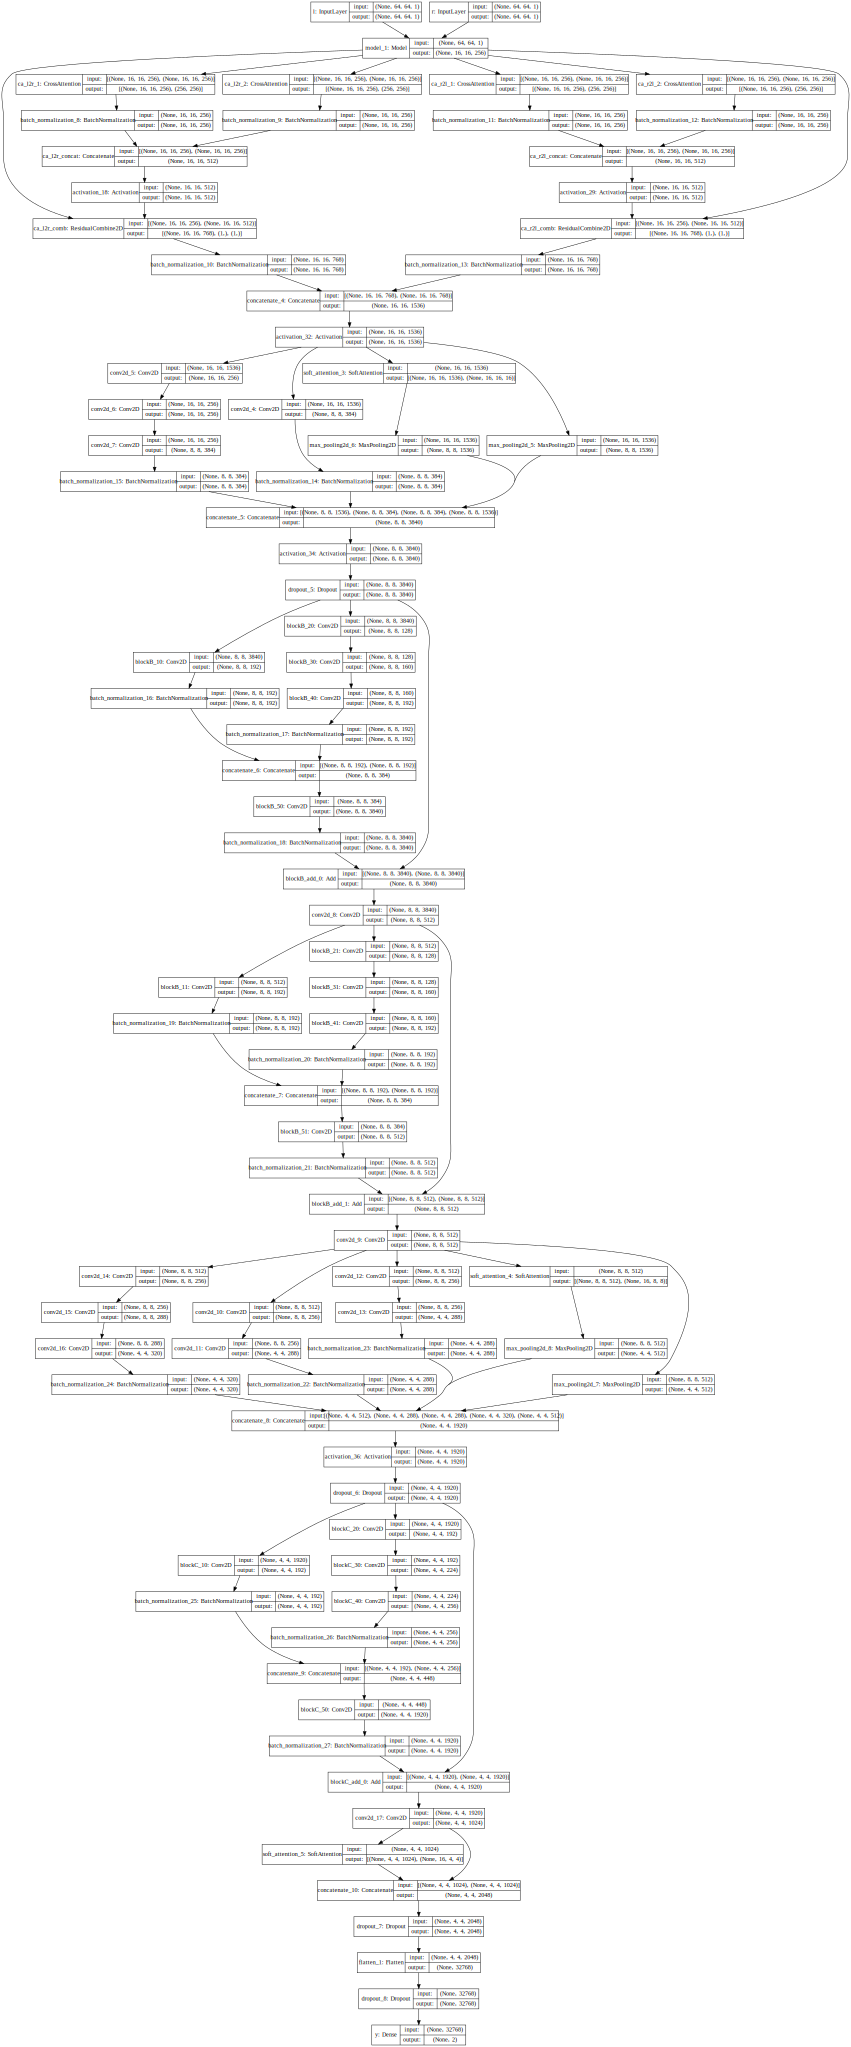

In [13]:
SVG(model_to_dot(model,show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [14]:
nb_fold = 1
df_tr = pd.read_csv('dataset/kfold_csvs/fold_{0}/train.csv'.format(nb_fold))
df_v = pd.read_csv('dataset/kfold_csvs/fold_{0}/val.csv'.format(nb_fold))
display(df_tr.shape,df_v.shape)
df_tr = df_tr.sort_values(by=['left','right','label']).reset_index()
df_v = df_v.sort_values(by=['left','right','label']).reset_index()

(504207, 4)

(30459, 4)

In [15]:
display(df_tr.head())

,index,Unnamed: 0,left,right,label
0,44642,44642,0001a_num1.png,0001b_num3.png,1
1,67417,67417,0001a_num1.png,0017b_num1.png,0
2,230576,230576,0001a_num1.png,0118c_num3.png,0
3,439468,439468,0001a_num1.png,0202c_num1.png,0
4,154608,154608,0001a_num1.png,0343a_num3.png,0


In [16]:
df_tr.shape

(504207, 5)

In [17]:
display(df_v.head()),df_v.shape

,index,Unnamed: 0,left,right,label
0,1028,1028,0001b_num1.png,0001c_num1.png,1
1,17828,17828,0001b_num1.png,0050c_num2.png,0
2,29813,29813,0001b_num1.png,0182a_num2.png,0
3,4741,4741,0001b_num1.png,0373a_num3.png,0
4,22296,22296,0001b_num1.png,0539a_num2.png,0


(None, (30459, 5))

In [18]:
def datagen(ds,batch_size=128,seq=False,mode=''):
    counter=0
    l,r,y,names = [],[],[],[]
    idx = 0
    while True:
        i=np.random.randint(0,ds.shape[0],1)[0]
        if seq:
            i = idx
            idx+=1
        d = ds.iloc[i]        
        l.append((255.0 - np.expand_dims(cv2.imread(os.path.join(ds_folder,d.left),0),axis=-1))/255.0)
        r.append((255.0 - np.expand_dims(cv2.imread(os.path.join(ds_folder,d.right),0),axis=-1))/255.0)
#         im = np.concatenate((l,r),axis=-1)  
        names.append([d.left,d.right])
        y.append(d.label)
        counter+=1
        
        r.append((255.0 - np.expand_dims(cv2.imread(os.path.join(ds_folder,d.left),0),axis=-1))/255.0)
        l.append((255.0 - np.expand_dims(cv2.imread(os.path.join(ds_folder,d.right),0),axis=-1))/255.0)
#         im = np.concatenate((l,r),axis=-1)  
        names.append([d.right,d.left])
        y.append(d.label)
        
        counter+=1
#         print('---',mode,'---',names)
        if ds.shape[0]==idx:
            idx = 0
        if counter==batch_size:
            inputs={
                'l':np.array(l)
                ,'r':np.array(r)
            }
            outputs={
#                 'y':np.array(y)
                'y':np_utils.to_categorical(y,num_classes=2)
                ,'names':np.array(names)
            }
            yield inputs,outputs
            counter=0
            l,r,y,names = [],[],[],[]

In [19]:
def categorical_focal_loss(gamma=2.0, alpha=0.75):
    def focal_loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        cross_entropy = -y_true*K.log(y_pred)
#         print(K.get_value(y_true))
        alpha_factor = K.ones_like(y_true)*alpha
        a_t = K.tf.where(K.equal(K.argmax(y_true),1),alpha_factor, 1.0-alpha_factor)
#         print(a)
        weight = a_t * y_true * K.pow((1-y_pred), gamma)
        loss = weight * cross_entropy
        loss = K.sum(loss, axis=1)
        return loss    
    return focal_loss

In [20]:
tr_batch_size=192
val_batch_size=512
tr_gen = datagen(df_tr,batch_size=tr_batch_size,seq=True,mode='train')
v_gen = datagen(df_v,batch_size=val_batch_size,seq=True,mode='val')

In [21]:
inputs,outputs=next(tr_gen)
l,r,y = inputs['l'],inputs['r'],outputs['y']

In [22]:
l.shape,r.shape,y.shape

((192, 64, 64, 1), (192, 64, 64, 1), (192, 2))

In [25]:
pred = feat_ext_A.predict(l)

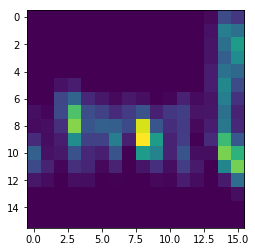

In [26]:
plt.imshow(pred[0][:,:,4])

In [25]:
# plt.imshow(l[0].reshape((64,64)))
# plt.show()
# plt.imshow(r[0].reshape((64,64)))
# plt.show()
# print(y[0])

In [26]:

total = df_tr.shape[0]
pos = df_tr[df_tr['label']==1].shape[0]
neg = total-pos
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 0.55, 1: 5.5}

In [23]:
model.compile(loss=categorical_focal_loss(),optimizer=Adam(lr=0.0001,decay=1e-06),metrics=['accuracy'])

In [28]:
parallel_model=multi_gpu_model(model, gpus=3)
parallel_model.compile(loss=categorical_focal_loss(),optimizer=Adam(lr=0.0001,decay=1e-06),metrics=['accuracy']) #For multi GPU
parallel_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
l (InputLayer)                  (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
r (InputLayer)                  (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 64, 64, 1)    0           l[0][0]                          
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 64, 64, 1)    0           r[0][0]                          
__________________________________________________________________________________________________
lambda_3 (

In [29]:
class MultiGPUCheckpoint(ModelCheckpoint):    
    def set_model(self, model):
        if isinstance(model.layers[-2], Model):
            self.model = model.layers[-2]
        else:
            self.model = model

In [30]:
if not os.path.exists('./checkpoints/ICFHR2020/'):
    os.mkdir('./checkpoints/ICFHR2020/')
mc=MultiGPUCheckpoint(filepath='./checkpoints/ICFHR2020/cross_attention_residual_irv2_fold_{0}.h5'.format(nb_fold)
                      ,monitor='val_loss'
                      ,period=1
                      ,save_best_only=True
                      ,save_weights_only=True
                      ,mode='auto'
                      ,verbose=1)
es=EarlyStopping(patience=20
                 ,monitor='val_loss'
                 ,min_delta=0.0001
                 ,mode='auto')
tb=TensorBoard(log_dir="./runs/cross_attention_residual_irv2_fold_{0}_{1}".format(nb_fold,time()))

In [ ]:
Epochs=100
h=parallel_model.fit_generator(tr_gen,initial_epoch=0,callbacks=[mc,es,tb],epochs=Epochs,steps_per_epoch=2*((df_tr.shape[0]//tr_batch_size)+1)
                      ,validation_data=v_gen, validation_steps=2*60, verbose=1)
                               #,class_weight=class_weight)

Epoch 1/100
5254/5254 [==============================] - 2908s 553ms/step - loss: 0.0684 - acc: 0.8645 - val_loss: 0.0446 - val_acc: 0.9094

Epoch 00001: val_loss improved from inf to 0.04458, saving model to ./checkpoints/ICFHR2020/cross_attention_residual_irv2_fold_1.h5
Epoch 2/100
5254/5254 [==============================] - 2452s 467ms/step - loss: 0.0365 - acc: 0.8994 - val_loss: 0.0764 - val_acc: 0.1584

Epoch 00002: val_loss did not improve from 0.04458
Epoch 3/100
5254/5254 [==============================] - 2453s 467ms/step - loss: 0.0311 - acc: 0.9006 - val_loss: 0.0466 - val_acc: 0.6431

Epoch 00003: val_loss did not improve from 0.04458
Epoch 4/100
5254/5254 [==============================] - 2450s 466ms/step - loss: 0.0287 - acc: 0.9138 - val_loss: 0.0351 - val_acc: 0.8359

Epoch 00004: val_loss improved from 0.04458 to 0.03509, saving model to ./checkpoints/ICFHR2020/cross_attention_residual_irv2_fold_1.h5
Epoch 5/100
5254/5254 [==============================] - 2450s 466

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5254/5254 [==============================] - 2448s 466ms/step - loss: 0.0177 - acc: 0.9453 - val_loss: 0.0250 - val_acc: 0.9378

Epoch 00035: val_loss did not improve from 0.02409
Epoch 36/100
5254/5254 [==============================] - 2453s 467ms/step - loss: 0.0171 - acc: 0.9462 - val_loss: 0.0313 - val_acc: 0.9391

Epoch 00036: val_loss did not improve from 0.02409
Epoch 37/100
5254/5254 [==============================] - 2449s 466ms/step - loss: 0.0173 - acc: 0.9468 - val_loss: 0.0395 - val_acc: 0.9327

Epoch 00037: val_loss did not improve from 0.02409
Epoch 38/100
 364/5254 [=>............................] - ETA: 37:16 - loss: 0.0173 - acc: 0.9458

# Evaluation

In [24]:
model.load_weights('./checkpoints/ICFHR2020/cross_attention_residual_irv2_fold_1.h5')

In [27]:
v_gen = datagen(df_v,batch_size=256,seq=True)
inputs,outputs=next(v_gen)
test_x,test_y = inputs,outputs['y']

In [33]:
soft_attention_1 = Model(feat_ext_A.inputs,feat_ext_A.get_layer('soft_attention_1').output)
feats_sa1,maps_sa1 = soft_attention_1.predict(test_x['l'])
soft_attention_2 = Model(feat_ext_A.inputs,feat_ext_A.get_layer('soft_attention_2').output)
feats_sa2,maps_sa2 = soft_attention_2.predict(test_x['l'])
soft_attention_3 = Model(model.inputs,model.get_layer('soft_attention_3').output)
feats_sa3,maps_sa3 = soft_attention_3.predict(test_x)
soft_attention_4 = Model(model.inputs,model.get_layer('soft_attention_4').output)
feats_sa4,maps_sa4 = soft_attention_4.predict(test_x) 
soft_attention_5 = Model(model.inputs,model.get_layer('soft_attention_5').output)
feats_sa5,maps_sa5 = soft_attention_5.predict(test_x)




ca_l2r_comb_model = Model(model.inputs,model.get_layer('ca_l2r_comb').output)
f_ca_l2r_comb,l2r_g1,l2r_g2 = ca_l2r_comb_model.predict(test_x)

ca_r2l_comb_model = Model(model.inputs,model.get_layer('ca_r2l_comb').output)
f_ca_r2l_comb,r2l_g1,r2l_g2 = ca_r2l_comb_model.predict(test_x)

ca_l2r_1_model = Model(model.inputs,model.get_layer('ca_l2r_1').output)
f_ca_l2r_1,maps_l2r_1 = ca_l2r_1_model.predict(test_x)

ca_l2r_2_model = Model(model.inputs,model.get_layer('ca_l2r_2').output)
f_ca_l2r_2,maps_l2r_2 = ca_l2r_2_model.predict(test_x)

ca_r2l_1_model = Model(model.inputs,model.get_layer('ca_r2l_1').output)
f_ca_r2l_1,maps_r2l_1 = ca_r2l_1_model.predict(test_x)

ca_r2l_2_model = Model(model.inputs,model.get_layer('ca_r2l_2').output)
f_ca_r2l_2,maps_r2l_2 = ca_r2l_2_model.predict(test_x)

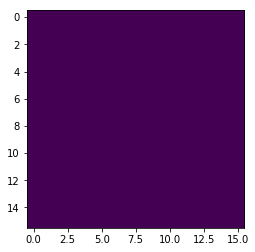

In [34]:
plt.imshow(f_ca_l2r_comb[0][:,:,703])

In [35]:
mapl  = maps_l2r_1+maps_l2r_2
mapl.shape
mapr  = maps_r2l_1+maps_r2l_2
mapr.shape

(256, 256, 256)

In [59]:
image_index = 22
print(outputs['names'][image_index])

['0002a_num3.png' '0832c_num2.png']


In [60]:
l2r_g1[image_index],l2r_g2[image_index],r2l_g1[image_index],r2l_g2[image_index]

(0.9829763, 0.45644554, 1.0287254, 0.8151321)

In [61]:
resized_left_img = cv2.resize(test_x['l'][image_index],(16,16),cv2.INTER_CUBIC)
resized_right_img = cv2.resize(test_x['r'][image_index],(16,16),cv2.INTER_CUBIC)

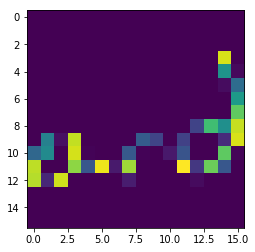

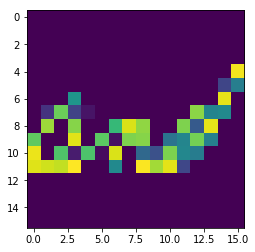

In [62]:
plt.imshow(resized_left_img)
plt.show()
plt.imshow(resized_right_img)
plt.show()

In [63]:
def getRowCol(point):
    row = point//16
    col = point%16
    return row,col

# of query pixels (useful pixels from right image): 56
matched left_points: 0


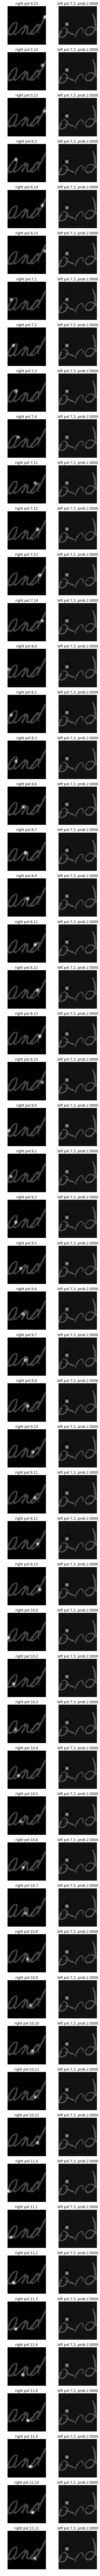

In [64]:
'''
To visualize a right image query pixel (query image) 'q_pix' 
that matches with k pixels of left image (key image)
- chose map_r2l_<x>
- select a row 'r' in it.
- reshap to 16x16 and resize to 64x64.
- apply as mask on left image.
'''

shape = (16,16)
right_useful_pixels = []
for i in range(len(resized_right_img)):
    for j in range(len(resized_right_img)):
        if resized_right_img[i][j] > 0:
            right_useful_pixels.append([i,j])
            
left_useful_pixels = []
for i in range(len(resized_left_img)):
    for j in range(len(resized_left_img)):
        if resized_left_img[i][j] > 0:
            left_useful_pixels.append([i,j])
            
print('# of query pixels (useful pixels from right image):',len(right_useful_pixels))
f, axarr = plt.subplots(nrows=len(right_useful_pixels),ncols=2,figsize=(6,3*len(right_useful_pixels)))

counter=0
left_points = 0
for i,j in right_useful_pixels:# no transparent/black pixels
#     print(i,j)
    pixel_num = (i*16)+j
#     print('pixel_num:',pixel_num)
    argmax=np.argmax(mapr[image_index][pixel_num])
    prob=mapr[image_index][pixel_num][argmax]
#     print('argmax:',argmax)
    row,col = getRowCol(argmax)
#     print([row,col])
    if [row,col] in left_useful_pixels:
        left_points += 1
        left_useful_pixels.remove([row,col])
    
    key_point = np.zeros((16,16))
    key_point[i][j] = 1.0
    resized_key_point = cv2.resize(key_point,(64,64),cv2.INTER_CUBIC)
    axarr[counter,0].imshow(resized_key_point,cmap='gray')
    axarr[counter,0].imshow(np.squeeze(test_x['r'][image_index],-1),alpha=0.3,cmap='gray')
    
    axarr[counter,1].imshow(cv2.resize(mapr[image_index][pixel_num].reshape(shape),(64,64),interpolation=cv2.INTER_CUBIC),cmap='gray')
    axarr[counter,1].imshow(np.squeeze(test_x['l'][image_index],-1),alpha=0.3,cmap='gray')
    axarr[counter,0].set_title('right pxl:{0},{1}'.format(i,j))
    axarr[counter,1].set_title('left pxl:{0},{1}, prob:{2:.4f}'.format(row,col,prob))
    axarr[counter,0].axis('off')
    axarr[counter,1].axis('off')
    counter+=1
    
print('matched left_points:',left_points)

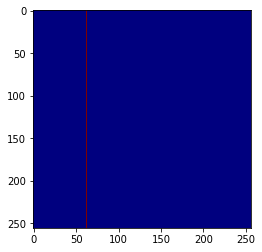

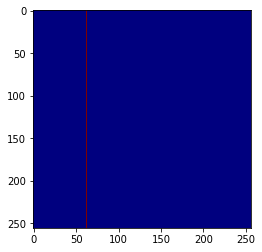

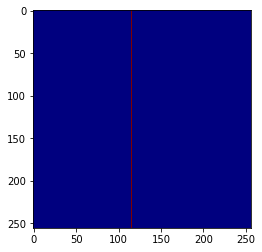

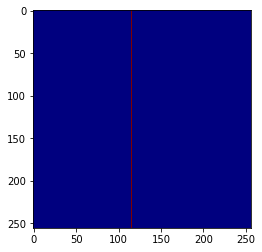

In [65]:
plt.imshow(maps_l2r_1[image_index],cmap='jet')
plt.show()
plt.imshow(maps_l2r_2[image_index],cmap='jet')
plt.show()
plt.imshow(maps_r2l_1[image_index],cmap='jet')
plt.show()
plt.imshow(maps_r2l_2[image_index],cmap='jet')
plt.show()

-----**********visualize SA1 maps************-----


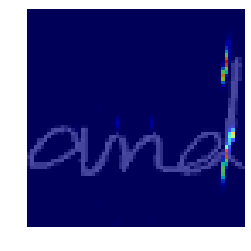

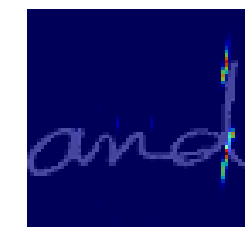

-----**********visualize SA2 maps************-----


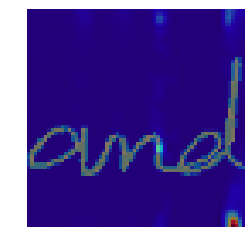

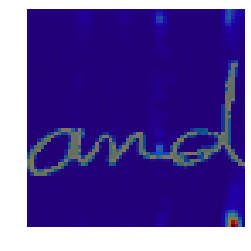

-----**********visualize SA3 maps************-----


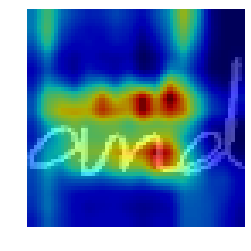

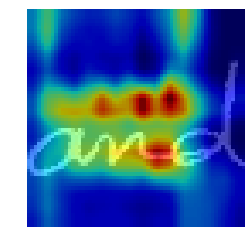

-----**********visualize SA4 maps************-----


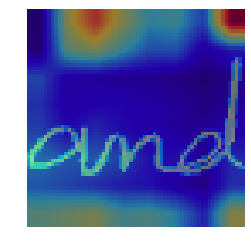

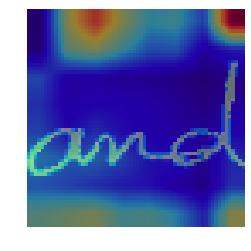

-----**********visualize SA5 maps************-----


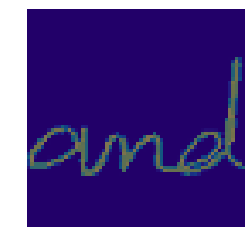

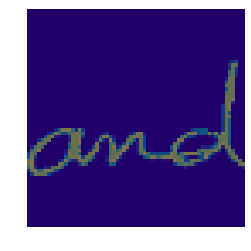

In [46]:
print('-----**********visualize SA1 maps************-----')
plt.axis('off')
plt.imshow(cv2.resize(maps_sa1[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_CUBIC),cmap='jet')
plt.imshow(np.squeeze(test_x['l'][image_index],-1),cmap='gray',alpha=0.3)
plt.show()
print("================================")
plt.axis('off')
plt.imshow(cv2.resize(maps_sa1[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_CUBIC),cmap='jet')
plt.imshow(np.squeeze(test_x['r'][image_index],-1),cmap='gray',alpha=0.3)
plt.show()

print('-----**********visualize SA2 maps************-----')
plt.axis('off')
plt.imshow(np.squeeze(test_x['l'][image_index],-1))
plt.imshow(cv2.resize(maps_sa2[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
plt.show()
print("================================")
plt.axis('off')
plt.imshow(np.squeeze(test_x['r'][image_index],-1))
plt.imshow(cv2.resize(maps_sa2[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
plt.show()

print('-----**********visualize SA3 maps************-----')
plt.axis('off')

plt.imshow(cv2.resize(maps_sa3[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_LINEAR),cmap='jet')
plt.imshow(np.squeeze(test_x['l'][image_index],-1),cmap='gray',alpha=0.3)
plt.show()
print("================================")
plt.axis('off')

plt.imshow(cv2.resize(maps_sa3[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_LINEAR),cmap='jet')
plt.imshow(np.squeeze(test_x['r'][image_index],-1),cmap='gray',alpha=0.3)
plt.show()



print('-----**********visualize SA4 maps************-----')
plt.axis('off')
plt.imshow(np.squeeze(test_x['l'][image_index],-1))
plt.imshow(cv2.resize(maps_sa4[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_LINEAR),cmap='jet',alpha=0.5)
plt.show()
print("================================")
plt.axis('off')
plt.imshow(np.squeeze(test_x['r'][image_index],-1))
plt.imshow(cv2.resize(maps_sa4[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_LINEAR),cmap='jet',alpha=0.5)
plt.show()

print('-----**********visualize SA5 maps************-----')
plt.axis('off')
plt.imshow(np.squeeze(test_x['l'][image_index],-1))
plt.imshow(cv2.resize(maps_sa5[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
plt.show()
print("================================")
plt.axis('off')
plt.imshow(np.squeeze(test_x['r'][image_index],-1))
plt.imshow(cv2.resize(maps_sa5[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_LINEAR),cmap='jet',alpha=0.5)
plt.show()

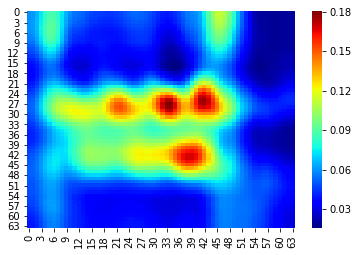

In [47]:
# sn.heatmap(maps2_r[image_index][j+i*26].reshape((26,26)),cmap='jet')
sn.heatmap(cv2.resize(maps_sa3[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_CUBIC),cmap='jet')
    

In [48]:
classnames=['Inter','Intra']

In [50]:
v_gen = datagen(df_v,batch_size=512,seq=True)
arr_test_y = []
arr_preds = []
for i in tqdm_notebook(range(2*(1+int(df_v.shape[0]/512)))):
    inputs,outputs=next(v_gen)
    test_x,test_y = inputs,outputs['y']
    predictions = model.predict(test_x)
    arr_test_y+=list(test_y)
    arr_preds+=list(predictions)
arr_test_y = np.array(arr_test_y)
arr_preds = np.array(arr_preds)
print(arr_test_y.shape)
print(arr_preds.shape)


(61440, 2)
(61440, 2)


In [51]:
arr_preds_logits = arr_preds.argmax(-1)
print(arr_preds[image_index],arr_preds_logits[image_index],arr_test_y[image_index])
# arr_preds_logits = np.array([1 if a>0.5 else 0 for a in arr_preds])
# arr_preds_logits,arr_test_y.argmax(-1)


[0.2175625 0.7824375] 1 [0. 1.]


In [52]:
df = pd.DataFrame()
f = classification_report(arr_test_y.argmax(-1),arr_preds_logits,target_names=classnames,output_dict=True)
df = df.from_dict(f)
display(df.T)

,f1-score,precision,recall,support
Inter,0.969548,0.964159,0.974996,55872.000000
Intra,0.674343,0.717206,0.636315,5568.000000
accuracy,0.944303,0.944303,0.944303,0.944303
macro avg,0.821945,0.840683,0.805656,61440.000000
weighted avg,0.942795,0.941779,0.944303,61440.000000


In [53]:
# true negatives is:math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
# :math:`C_{1,1}` and false positives is :math:`C_{0,1}`

In [54]:
cm=metrics.confusion_matrix(arr_test_y.argmax(-1),arr_preds_logits)
cm

array([[54475,  1397],
       [ 2025,  3543]])

In [55]:

def get_FPR_intra(cm):
    FP = cm[0][1]
    TN = cm[0][0]
    return FP/(FP+TN)
def get_FNR_intra(cm):
    FN = cm[1][0]
    TP = cm[1][1]
#     print(FN,'/',(FN+TP))
    return FN/(FN+TP)

In [56]:
get_FPR_intra(cm)*100,get_FNR_intra(cm)*100

(2.5003579610538376, 36.36853448275862)

In [57]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(3, 3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

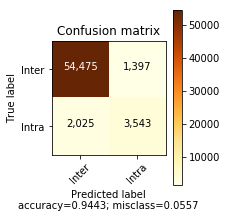

In [58]:
plot_confusion_matrix(cm=cm,cmap='YlOrBr',target_names=classnames, normalize=False)